In [10]:
!pip install evaluate
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.1 MB/s eta 0:00:00


In [97]:
import json
from tqdm import tqdm
import re
from collections import Counter
from evaluate import load
import pandas as pd
import matplotlib.gridspec as gridspec

In [25]:
# Function to get the correct answer
def get_gold(query_data, query):
  for q in query_data:
    if q['query'] == query:
      return q['answer']
  return ''

# Function to check if there is an intersection of words between two strings
def has_intersection(a, b):
  a_words = set(a.split())
  b_words = set(b.split())
  return len(a_words.intersection(b_words)) > 0

def get_idx(x,alist):
  for i,c in enumerate(alist):
    if c == x:
      return i
  return -1

def count_overlap(gold,pred):
  # Standardise by removing all non-alphanumeric characters.
  # The input should be lower cased. But to be safe ...
  g = gold.lower()
  p = pred.lower()
  cg = re.sub(r'[^A-Za-z0-9 ]+', '', g)
  cp = re.sub(r'[^A-Za-z0-9 ]+', '', p)
  gold_words = cg.split()
  pred_words = cp.split()
  glen = len(gold_words)
  plen = len(pred_words)

  # Somewhat destructive as it removes dupes, but is the only sensible way
  # to do it.
  #gold_words = list(set(gold_words))
  #pred_words = list(set(pred_words))
  cnt = 0
  for w in pred_words:
    rv = get_idx(w,gold_words)
    if rv != -1:
      cnt += 1
      v = gold_words.pop(rv)
  return cnt, glen, plen 

# Function to extract the answer from gold
def extract_answer(input_string):
  match = re.search(r'The answer to the question is "(.*?)"', input_string)
  return match.group(1) if match else input_string

def comp_metrics_new(pred_list, gold_list):
  prec_list = []
  recall_list = []
  f1_list = []
  for gold, pred in zip(gold_list, pred_list):
    c, plen, glen = count_overlap(gold,pred)

    # Compute Precision Directly
    if plen == 0:
      precision = 0.0
    else:
      precision = float(c)/plen

    # Compute Recall Directly
    if glen == 0:
      recall = 0
    else:
      recall = float(c)/glen

    if precision == 0.0 and recall == 0.0:
      f1 = 0.0
    else:
      f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    prec_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

  # You can modify this code easily to get the list of per query scores for all
  # three metrics.
  micro_prec = sum(prec_list)/len(prec_list)
  micro_recall = sum(recall_list)/len(recall_list)
  micro_f1 = sum(f1_list)/len(f1_list)

  return micro_prec, micro_recall, micro_f1, prec_list, recall_list, f1_list

# New function to compute BERTScore using Hugging Face's `evaluate` library
def comp_bert_score(pred_list, gold_list, lang="en"):
    bertscore = load("bertscore")  # Load the BERTScore metric
    results = bertscore.compute(predictions=pred_list, references=gold_list, lang=lang)
    
    precision = sum(results['precision']) / len(results['precision'])
    recall = sum(results['recall']) / len(results['recall'])
    f1 = sum(results['f1']) / len(results['f1'])

    return precision, recall, f1, results['precision'], results['recall'], results['f1']

In [26]:
def run_evaluation(predictions, gold_labels):
  # Read files
  with open(predictions, 'r') as fh:
    data = fh.read()
    doc_data = json.loads(data)

  #with open('dataset/MultiHopRAG.json', 'r') as file:
  with open(gold_labels, 'r') as fh:
    data = fh.read()
    query_data = json.loads(data)

  # Initialize dictionary to save lists of predictions and gold standards 
  # for each question_type
  # type_data = {}
  overall_pred_list = []
  overall_gold_list = []
  overall_q_type = []
  prec_list = []
  recall_list = []
  f1_list = []
  bert_prec_list = []
  bert_recall_list = []
  bert_f1_list = []

  #print(doc_data)
  # Main loop, iterate through document data
  for d in tqdm(doc_data):
    model_answer = d['model_answer']
    if 'The answer' in model_answer:
      model_answer = extract_answer(model_answer)
    gold = get_gold(query_data,d['query'])
    if gold:
      question_type = d['question_type']
      # if question_type not in type_data:
      #   type_data[question_type] = {'pred_list': [], 'gold_list': []}
      # type_data[question_type]['pred_list'].append(model_answer)
      # type_data[question_type]['gold_list'].append(gold)
      overall_pred_list.append(model_answer)
      overall_gold_list.append(gold)
      overall_q_type.append(question_type)
    
  # Output evaluation data for each question_type
  # for question_type, data in type_data.items():
  #   precision, recall, f1 = comp_metrics_new(data['pred_list'], data['gold_list'])
  #   bert_precision, bert_recall, bert_f1 = comp_bert_score(data['pred_list'], data['gold_list'])
  #   print(f"Question Type: {question_type}")
  #   print(f" Precision: {precision:.2f}")
  #   print(f" Recall: {recall:.2f}")
  #   print(f" F1 Score: {f1:.2f}")
  #   print(f" BERTScore Precision: {bert_precision:.4f}")
  #   print(f" BERTScore Recall: {bert_recall:.4f}")
  #   print(f" BERTScore F1: {bert_f1:.4f}")
  #   print()

  # Calculate overall evaluation metrics
  overall_precision, overall_recall, overall_f1, prec_list, recall_list, f1_list  = comp_metrics_new(overall_pred_list, overall_gold_list)
  bert_precision, bert_recall, bert_f1, bert_prec_list, bert_recall_list, bert_f1_list= comp_bert_score(overall_pred_list, overall_gold_list)
  
  return overall_q_type, overall_precision, overall_recall, overall_f1, prec_list, recall_list, f1_list, bert_precision, bert_recall, bert_f1, bert_prec_list, bert_recall_list, bert_f1_list


In [40]:
import pandas as pd

gold_labels = 'data/rag.json'
prediction_files = [
    'llama2_rankerB', 
    'llama2_rerankerD', 
    'llama3_rankerB', 
    'llama3_rerankerD', 
    'mistral_rankerB', 
    'mistral_rerankerD', 
    'zephyr_rankerB', 
    'zephyr_rerankerD'
]

# Dictionary to store data for the DataFrame
d = {
    'LLM': [], 
    'Retrieval': [], 
    'Question Type': [],
    'Precision': [], 
    'Recall': [], 
    'F1 Score': [], 
    'BERT Precision': [], 
    'BERT Recall': [], 
    'BERT F1 Score': []
}

# Iterate over the prediction files
for prediction_file in prediction_files: 
    # Run the evaluation function
    overall_q_type, overall_precision, overall_recall, overall_f1, \
    prec_list, recall_list, f1_list, \
    bert_precision, bert_recall, bert_f1, \
    bert_prec_list, bert_recall_list, bert_f1_list = run_evaluation('output/' + prediction_file + '.json', gold_labels)
    
    llm = prediction_file.split('_')[0]  # Extract LLM name
    retrieval = prediction_file.split('_')[1]  # Extract Retrieval method

    # For each question type, append the values into the dictionary
    for i, q_type in enumerate(overall_q_type):
        d['LLM'].append(llm)
        d['Retrieval'].append(retrieval)
        d['Question Type'].append(q_type)
        d['Precision'].append(prec_list[i])
        d['Recall'].append(recall_list[i])
        d['F1 Score'].append(f1_list[i])
        d['BERT Precision'].append(bert_prec_list[i])
        d['BERT Recall'].append(bert_recall_list[i])
        d['BERT F1 Score'].append(bert_f1_list[i])

    # Print overall metrics for the model
    print(f"Overall Metrics for {prediction_file}:")
    print(f" Precision: {overall_precision:.2f}")
    print(f" Recall: {overall_recall:.2f}")
    print(f" F1 Score: {overall_f1:.2f}")
    print(f" BERTScore Precision: {bert_precision:.4f}")
    print(f" BERTScore Recall: {bert_recall:.4f}")
    print(f" BERTScore F1: {bert_f1:.4f}")
    print('-' * 20)

# Create a DataFrame from the dictionary
df = pd.DataFrame(d)

100%|██████████| 2556/2556 [00:00<00:00, 9599.37it/s] 
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Overall Metrics for llama2_rankerB:
 Precision: 0.41
 Recall: 0.23
 F1 Score: 0.24
 BERTScore Precision: 0.8356
 BERTScore Recall: 0.8764
 BERTScore F1: 0.8550
--------------------


100%|██████████| 2556/2556 [00:00<00:00, 11622.90it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Overall Metrics for llama2_rerankerD:
 Precision: 0.42
 Recall: 0.24
 F1 Score: 0.25
 BERTScore Precision: 0.8387
 BERTScore Recall: 0.8779
 BERTScore F1: 0.8574
--------------------


100%|██████████| 2556/2556 [00:00<00:00, 11807.55it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Overall Metrics for llama3_rankerB:
 Precision: 0.34
 Recall: 0.34
 F1 Score: 0.34
 BERTScore Precision: 0.9002
 BERTScore Recall: 0.9385
 BERTScore F1: 0.9177
--------------------


100%|██████████| 2556/2556 [00:00<00:00, 10703.73it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Overall Metrics for llama3_rerankerD:
 Precision: 0.34
 Recall: 0.34
 F1 Score: 0.34
 BERTScore Precision: 0.9018
 BERTScore Recall: 0.9394
 BERTScore F1: 0.9190
--------------------


100%|██████████| 2556/2556 [00:00<00:00, 11691.41it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Overall Metrics for mistral_rankerB:
 Precision: 0.27
 Recall: 0.04
 F1 Score: 0.05
 BERTScore Precision: 0.7961
 BERTScore Recall: 0.8528
 BERTScore F1: 0.8231
--------------------


100%|██████████| 2556/2556 [00:00<00:00, 11907.64it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Overall Metrics for mistral_rerankerD:
 Precision: 0.28
 Recall: 0.04
 F1 Score: 0.05
 BERTScore Precision: 0.7964
 BERTScore Recall: 0.8535
 BERTScore F1: 0.8235
--------------------


100%|██████████| 2556/2556 [00:00<00:00, 11380.81it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Overall Metrics for zephyr_rankerB:
 Precision: 0.18
 Recall: 0.01
 F1 Score: 0.02
 BERTScore Precision: 0.7891
 BERTScore Recall: 0.8173
 BERTScore F1: 0.8025
--------------------


100%|██████████| 2556/2556 [00:00<00:00, 11438.55it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Overall Metrics for zephyr_rerankerD:
 Precision: 0.19
 Recall: 0.01
 F1 Score: 0.02
 BERTScore Precision: 0.7892
 BERTScore Recall: 0.8182
 BERTScore F1: 0.8031
--------------------


In [42]:
df.groupby(['LLM', 'Retrieval', 'Question Type']).mean()

Precision    Recall  F1 Score  \
LLM     Retrieval Question Type                                     
llama2  rankerB   comparison_query   0.207944  0.011108  0.014958   
                  inference_query    0.832261  0.697676  0.706911   
                  null_query         0.104651  0.008961  0.016114   
                  temporal_query     0.295026  0.022703  0.027719   
        rerankerD comparison_query   0.197430  0.017273  0.021045   
                  inference_query    0.843934  0.729225  0.736604   
                  null_query         0.112957  0.010019  0.017920   
                  temporal_query     0.310463  0.014901  0.020484   
llama3  rankerB   comparison_query   0.040888  0.033963  0.034737   
                  inference_query    0.834661  0.845221  0.837523   
                  null_query         0.262458  0.262458  0.262458   
                  temporal_query     0.116981  0.115352  0.115876   
        rerankerD comparison_query   0.040888  0.033356  0.033787   
                  inference_query    0.856107  0.866217  0.858666   
                  null_query         0.249169  0.248062  0.248505   
                  temporal_query     0.108634  0.108062  0.108176   
mistral rankerB   comparison_query   0.017523  0.000460  0.000858   
                  inference_query    0.764144  0.058526  0.096119   
                  null_query         0.167774  0.150456  0.151313   
                  temporal_query     0.014580  0.000905  0.001584   
        rerankerD comparison_query   0.012850  0.000218  0.000427   
                  inference_query    0.772927  0.055879  0.092957   
                  null_query         0.209302  0.199910  0.200418   
                  temporal_query     0.019726  0.001096  0.001913   
zephyr  rankerB   comparison_query   0.011682  0.000060  0.000120   
                  inference_query    0.477216  0.034198  0.062674   
                  null_query         0.134551  0.008099  0.014938   
                  temporal_query     0.021269  0.000319  0.000590   
        rerankerD comparison_query   0.012850  0.000074  0.000145   
                  inference_query    0.499479  0.035452  0.065159   
                  null_query         0.151163  0.012079  0.019501   
                  temporal_query     0.020926  0.000690  0.001232   

                                    BERT Precision  BERT Recall  BERT F1 Score  
LLM     Retrieval Question Type                                                 
llama2  rankerB   comparison_query        0.778390     0.835818       0.805869  
                  inference_query         0.942803     0.955572       0.948615  
                  null_query              0.811627     0.850263       0.830199  
                  temporal_query          0.781825     0.838629       0.808967  
        rerankerD comparison_query        0.781901     0.835199       0.807462  
                  inference_query         0.950703     0.961469       0.955585  
                  null_query              0.806910     0.849331       0.827144  
                  temporal_query          0.781834     0.838403       0.808890  
llama3  rankerB   comparison_query        0.858249     0.931172       0.891791  
                  inference_query         0.974799     0.970358       0.972280  
                  null_query              0.867799     0.878746       0.872849  
                  temporal_query          0.874295     0.935600       0.902666  
        rerankerD comparison_query        0.859769     0.930887       0.892533  
                  inference_query         0.976138     0.971418       0.973500  
                  null_query              0.865436     0.876290       0.870411  
                  temporal_query          0.878030     0.939541       0.906458  
mistral rankerB   comparison_query        0.784470     0.852610       0.817053  
                  inference_query         0.796764     0.844146       0.818948  
                  null_query              0.839933     0.869227      

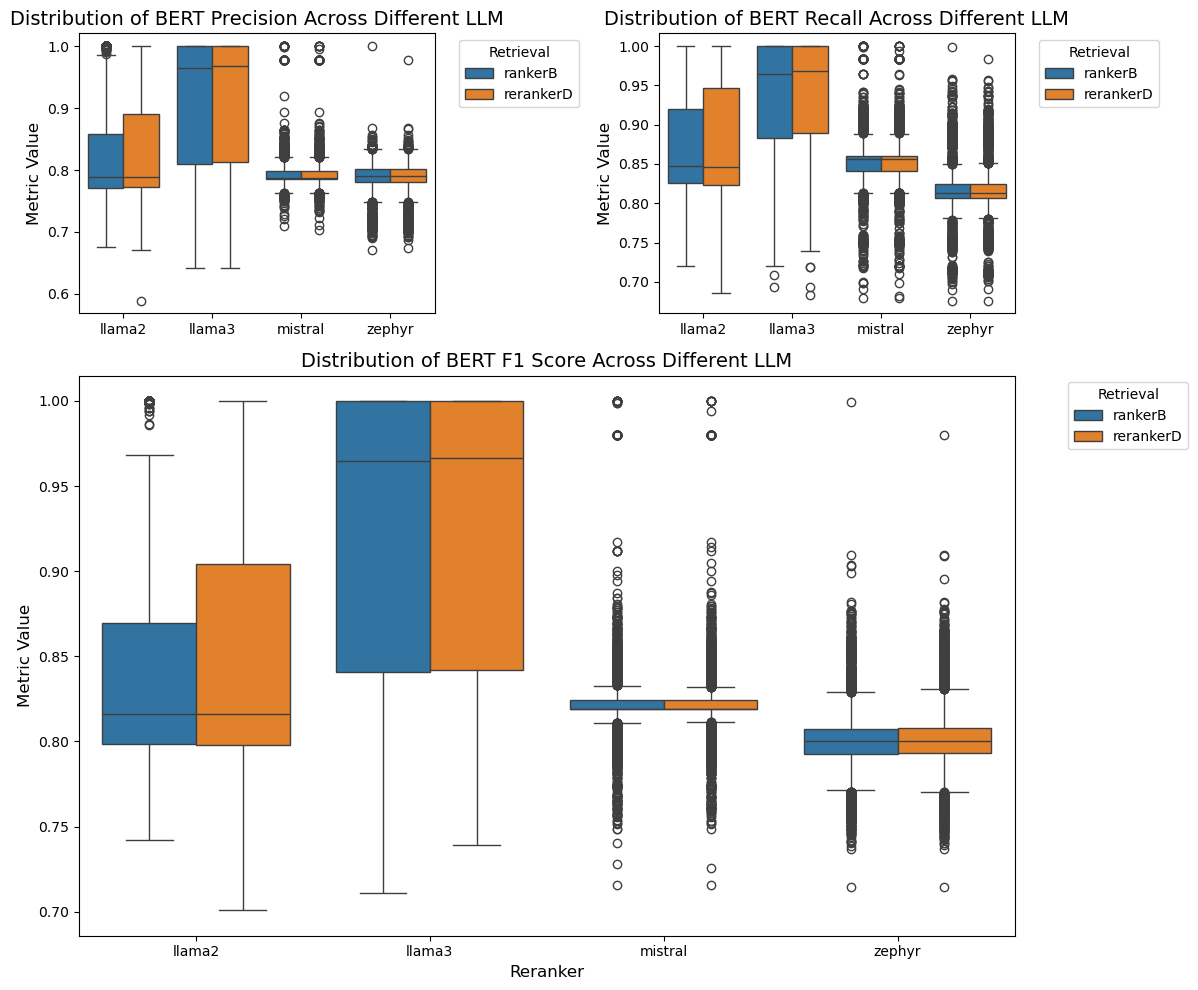

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
# List of metrics to plot
metrics_to_plot = ['BERT Precision', 'BERT Recall', 'BERT F1 Score']

# Create a figure with GridSpec to control the layout
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[1, 1])

# Plot BERT Precision in the first column of the first row
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(x='LLM', y='BERT Precision', data=df, hue='Retrieval', ax=ax1)
ax1.set_title('Distribution of BERT Precision Across Different LLM', fontsize=14)
ax1.set_ylabel('Metric Value', fontsize=12)
ax1.set_xlabel('')  # No x-axis label for the top row
ax1.legend(title='Retrieval', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot BERT Recall in the second column of the first row
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(x='LLM', y='BERT Recall', data=df, hue='Retrieval', ax=ax2)
ax2.set_title('Distribution of BERT Recall Across Different LLM', fontsize=14)
ax2.set_ylabel('Metric Value', fontsize=12)
ax2.set_xlabel('')  # No x-axis label for the top row
ax2.legend(title='Retrieval', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot BERT F1 Score in the entire second row
ax3 = fig.add_subplot(gs[1, :])  # Span across both columns
sns.boxplot(x='LLM', y='BERT F1 Score', data=df, hue='Retrieval', ax=ax3)
ax3.set_title('Distribution of BERT F1 Score Across Different LLM', fontsize=14)
ax3.set_ylabel('Metric Value', fontsize=12)
ax3.set_xlabel('Reranker', fontsize=12)
ax3.legend(title='Retrieval', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

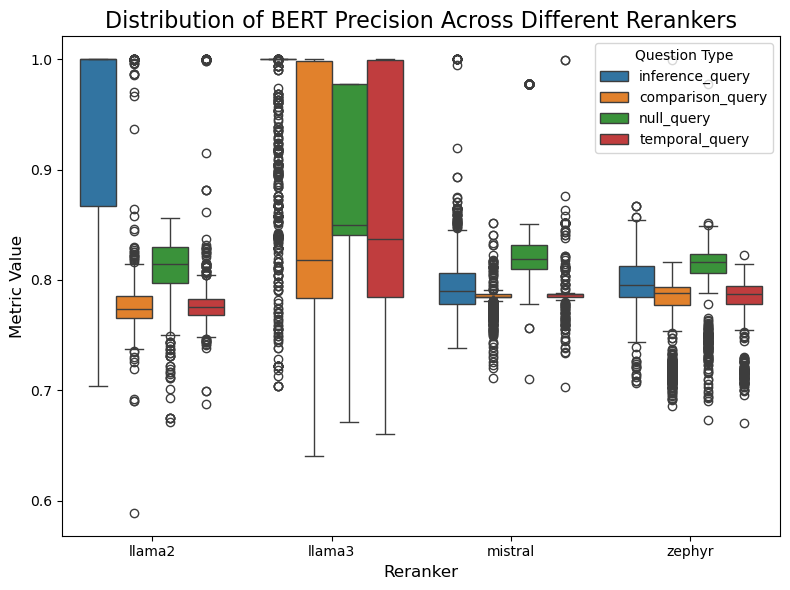

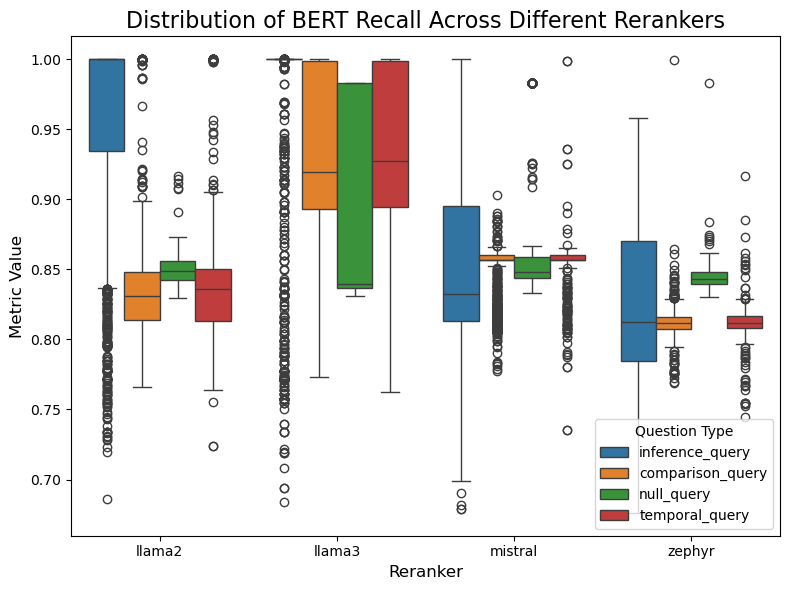

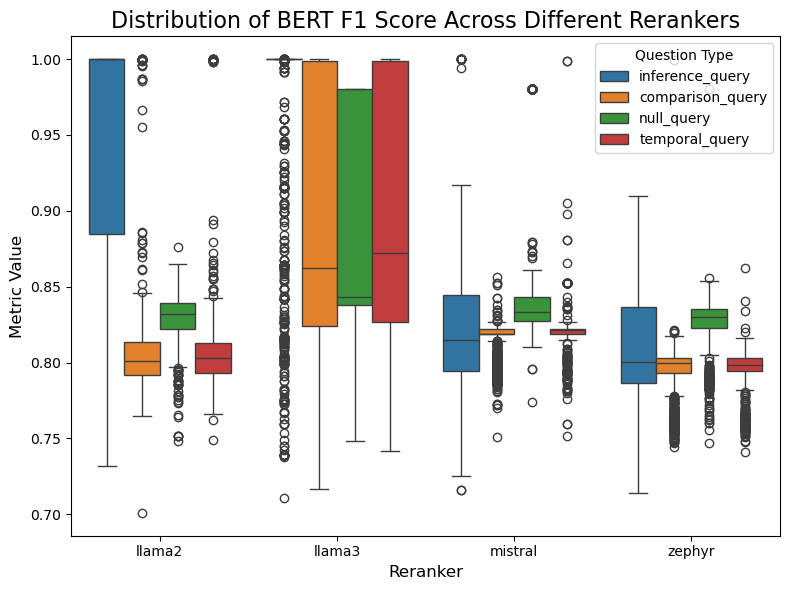

In [48]:
# List of metrics to plot
metrics_to_plot = ['BERT Precision', 'BERT Recall', 'BERT F1 Score']

# Generate a separate boxplot for each metric
for metric in metrics_to_plot:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='LLM', y=metric, data=df,  hue=df['Question Type'])
    
    # Customize the plot
    plt.title(f'Distribution of {metric} Across Different Rerankers', fontsize=16)
    plt.ylabel('Metric Value', fontsize=12)
    plt.xlabel('Reranker', fontsize=12)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [49]:
len(df)

20448

In [116]:
time_files = [
    'time/output/llama2_rankerB.json', 
    'time/output/llama2_rerankerD.json', 
    'time/output/llama3_rankerB.json', 
    'time/output/llama3_rerankerD.json', 
    'time/output/mistral_rankerB.json', 
    'time/output/mistral_rerankerD.json', 
    'time/output/zephyr_rankerB.json', 
    'time/output/zephyr_rerankerD.json'
]

time_taken = []

for time_file in time_files:
    with open(time_file, 'r') as fh:
        data = fh.read()
        time_data = json.loads(data)

    for d in tqdm(time_data):
        time_taken.append(d)

100%|██████████| 2556/2556 [00:00<00:00, 2369202.44it/s]


In [117]:
len(time_taken)

20448

In [118]:
df.insert(9, 'Time Taken', time_taken)

ValueError: cannot insert Time Taken, already exists

In [120]:
# Save to CSV (optional)
# df.to_csv('evaluation_metrics.csv', index=False)

In [121]:
df.head()

,LLM,Retrieval,Question Type,Precision,Recall,F1 Score,BERT Precision,BERT Recall,BERT F1 Score,Time Taken
0,llama2,rankerB,inference_query,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.988079
1,llama2,rankerB,inference_query,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.125932
2,llama2,rankerB,inference_query,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.146070
3,llama2,rankerB,comparison_query,0.0,0.000000,0.000000,0.768849,0.842385,0.803939,7.956295
4,llama2,rankerB,inference_query,1.0,0.068966,0.129032,0.808072,0.911477,0.856665,2.834203


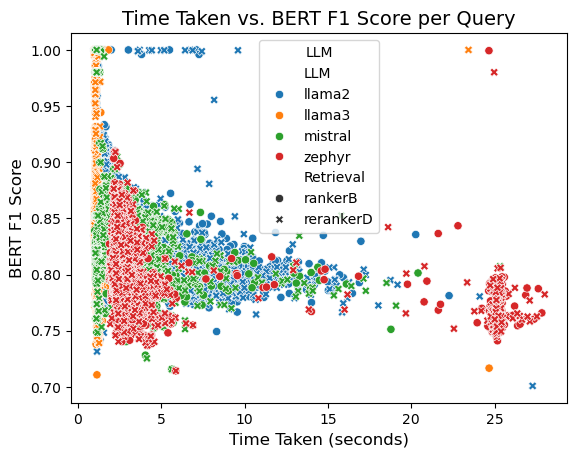

In [133]:
sns.scatterplot(data=df, x="Time Taken", y="BERT F1 Score", hue="LLM", style="Retrieval")

# Add labels and title
plt.title('Time Taken vs. BERT F1 Score per Query', fontsize=14)
plt.xlabel('Time Taken (seconds)', fontsize=12)
plt.ylabel('BERT F1 Score', fontsize=12)
plt.legend(title='LLM')

# Show plot
plt.show()

In [100]:
df_grouped_avg = df.groupby(['LLM', 'Retrieval', 'Question Type']).mean()
df_grouped_avg

Precision    Recall  F1 Score  \
LLM     Retrieval Question Type                                     
llama2  rankerB   comparison_query   0.207944  0.011108  0.014958   
                  inference_query    0.832261  0.697676  0.706911   
                  null_query         0.104651  0.008961  0.016114   
                  temporal_query     0.295026  0.022703  0.027719   
        rerankerD comparison_query   0.197430  0.017273  0.021045   
                  inference_query    0.843934  0.729225  0.736604   
                  null_query         0.112957  0.010019  0.017920   
                  temporal_query     0.310463  0.014901  0.020484   
llama3  rankerB   comparison_query   0.040888  0.033963  0.034737   
                  inference_query    0.834661  0.845221  0.837523   
                  null_query         0.262458  0.262458  0.262458   
                  temporal_query     0.116981  0.115352  0.115876   
        rerankerD comparison_query   0.040888  0.033356  0.033787   
                  inference_query    0.856107  0.866217  0.858666   
                  null_query         0.249169  0.248062  0.248505   
                  temporal_query     0.108634  0.108062  0.108176   
mistral rankerB   comparison_query   0.017523  0.000460  0.000858   
                  inference_query    0.764144  0.058526  0.096119   
                  null_query         0.167774  0.150456  0.151313   
                  temporal_query     0.014580  0.000905  0.001584   
        rerankerD comparison_query   0.012850  0.000218  0.000427   
                  inference_query    0.772927  0.055879  0.092957   
                  null_query         0.209302  0.199910  0.200418   
                  temporal_query     0.019726  0.001096  0.001913   
zephyr  rankerB   comparison_query   0.011682  0.000060  0.000120   
                  inference_query    0.477216  0.034198  0.062674   
                  null_query         0.134551  0.008099  0.014938   
                  temporal_query     0.021269  0.000319  0.000590   
        rerankerD comparison_query   0.012850  0.000074  0.000145   
                  inference_query    0.499479  0.035452  0.065159   
                  null_query         0.151163  0.012079  0.019501   
                  temporal_query     0.020926  0.000690  0.001232   

                                    BERT Precision  BERT Recall  \
LLM     Retrieval Question Type                                   
llama2  rankerB   comparison_query        0.778390     0.835818   
                  inference_query         0.942803     0.955572   
                  null_query              0.811627     0.850263   
                  temporal_query          0.781825     0.838629   
        rerankerD comparison_query        0.781901     0.835199   
                  inference_query         0.950703     0.961469   
                  null_query              0.806910     0.849331   
                  temporal_query          0.781834     0.838403   
llama3  rankerB   comparison_query        0.858249     0.931172   
                  inference_query         0.974799     0.970358   
                  null_query              0.867799     0.878746   
                  temporal_query          0.874295     0.935600   
        rerankerD comparison_query        0.859769     0.930887   
                  inference_query         0.976138     0.971418   
                  null_query              0.865436     0.876290   
                  temporal_query          0.878030     0.939541   
mistral rankerB   comparison_query        0.784470     0.852610   
                  inference_query         0.796764     0.844146   
                  null_query              0.839933     0.869227   
                  temporal_query          0.789781     0.856720   
        rerankerD comparison_query        0.784373     0.853587   
                  inference_query         0.795797     0.843799   
                  null_query              0.847986     0.875312   
              

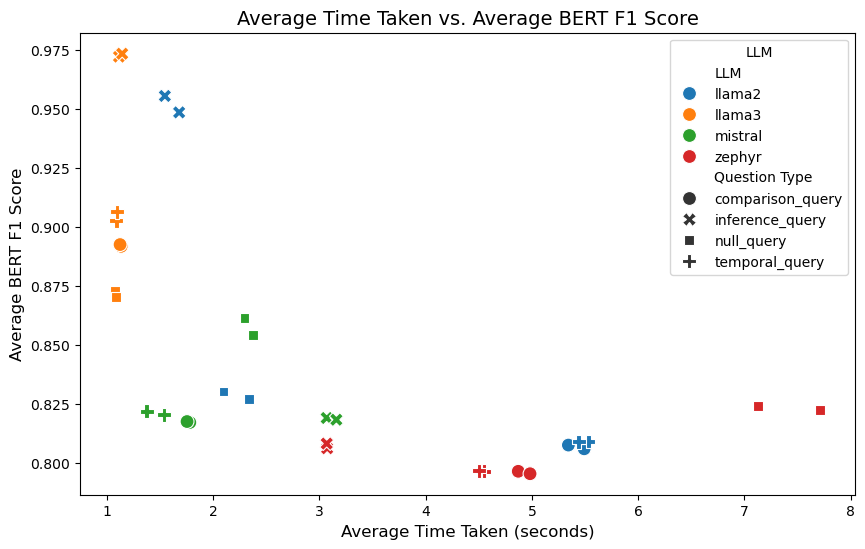

In [128]:
# Group the data by LLM, Retrieval, and Question Type, and calculate the mean values
df_grouped_res = df_grouped_avg.reset_index()

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_grouped_res, 
    x='Time Taken', 
    y='BERT F1 Score', 
    hue='LLM', 
    style='Question Type', 
    s=100  # Adjust point size if needed
)

# Add labels and title
plt.title('Average Time Taken vs. Average BERT F1 Score', fontsize=14)
plt.xlabel('Average Time Taken (seconds)', fontsize=12)
plt.ylabel('Average BERT F1 Score', fontsize=12)
plt.legend(title='LLM')

# Show plot
plt.show()

In [129]:
# Group the data and apply different aggregations
df_grouped_tot = df.groupby(['LLM', 'Retrieval']).agg(
    {
        'Precision': 'mean',
        'Recall': 'mean',
        'F1 Score': 'mean',
        'BERT Precision': 'mean',
        'BERT Recall': 'mean',
        'BERT F1 Score': 'mean',
        'Time Taken': 'sum'  # Sum for Time Taken
    }
)

# Display the grouped DataFrame
df_grouped_tot['Time Taken'] = df_grouped_tot['Time Taken'] / 3600

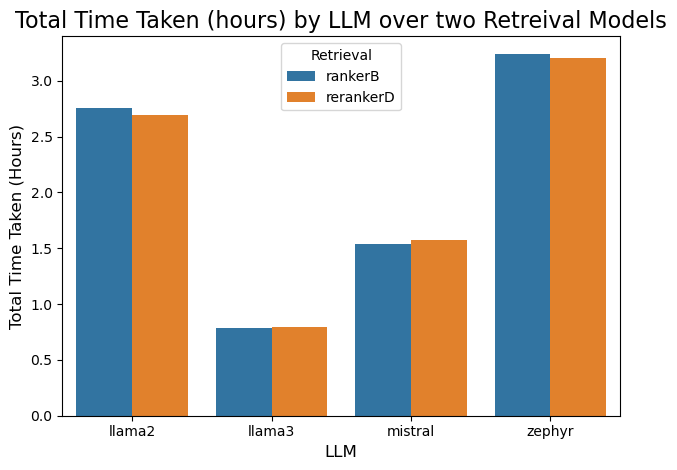

In [130]:
sns.barplot(data=df_grouped_tot, x="LLM", y="Time Taken", hue="Retrieval")

# Customize the plot
plt.title('Total Time Taken (hours) vs LLM over two Retreival Models', fontsize=16)
plt.xlabel('LLM', fontsize=12)
plt.ylabel('Total Time Taken (Hours)', fontsize=12)  # Add the unit to the y-axis label

# Show the plot
plt.tight_layout()
plt.show()

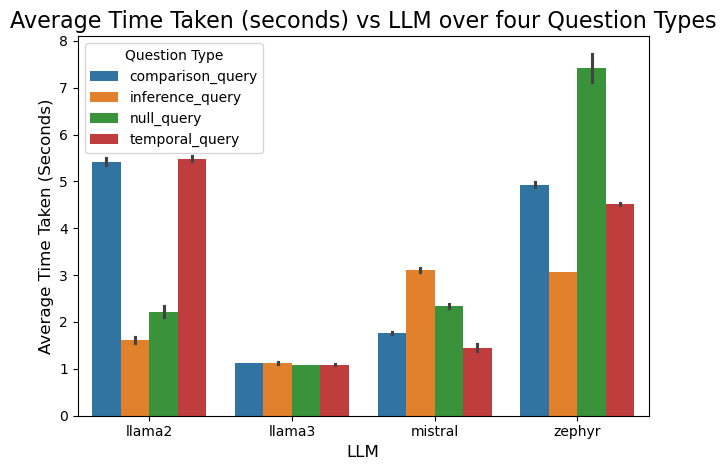

In [132]:
sns.barplot(data=df_grouped_avg, x="LLM", y="Time Taken", hue="Question Type")

# Customize the plot
plt.title('Average Time Taken (seconds) vs LLM over four Question Types', fontsize=16)
plt.xlabel('LLM', fontsize=12)
plt.ylabel('Average Time Taken (Seconds)', fontsize=12)  # Add the unit to the y-axis label

# Show the plot
plt.tight_layout()
plt.show()